# Variational AutoEncoders for Image Generation.
Finally something new!

# AutoEncoder for image reconstruction

To show simple results I'll use MNIST for this one.

In [35]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import os

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [37]:
train_dataset = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

train_dataset, val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [38]:
m_samples = len(train_dataset)
train_ratio = 0.8
indices = np.arange(m_samples)
np.random.shuffle(indices)

train_indices = indices[:int(train_ratio * m_samples)]
val_indices = indices[int(train_ratio * m_samples):]

train_sampler = RandomSampler(train_indices)
val_sampler = RandomSampler(val_indices)

train_dataloader = DataLoader(
    train_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count(), sampler=train_sampler
)
val_dataloader = DataLoader(
    val_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count(), sampler=val_sampler
)
test_dataloader = DataLoader(
    test_dataset, batch_size=128, pin_memory=True, num_workers=os.cpu_count()
)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(375, 94, 79)

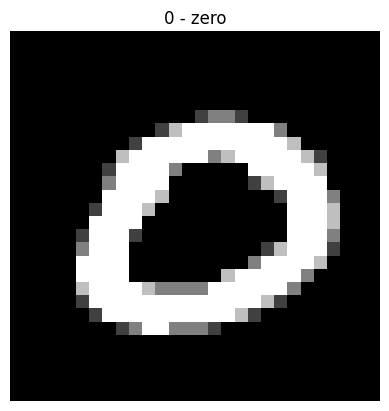

In [39]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0]
    label = label_batch[0]

    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0), cmap="gray");
    break

## Let's build autoencoder now!

In [40]:
class Encoder(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2),  # 13x13x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2),  # 6x6x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=2),  # 4x4x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 2, kernel_size=3, stride=2, padding=1),  # 2x2x2
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        # return torch.reshape(self.encoder(x), (128, 8, 1, 1))
        x = self.encoder(x)
        batch_size = x.shape[0]
        return x.view(batch_size, 8, 1, 1)

In [41]:
encoda = Encoder(1)
summary(encoda, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [128, 8, 1, 1]            --
├─Sequential: 1-1                        [128, 8]                  --
│    └─Conv2d: 2-1                       [128, 32, 13, 13]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 13, 13]         64
│    └─ReLU: 2-3                         [128, 32, 13, 13]         --
│    └─Conv2d: 2-4                       [128, 16, 6, 6]           4,624
│    └─BatchNorm2d: 2-5                  [128, 16, 6, 6]           32
│    └─ReLU: 2-6                         [128, 16, 6, 6]           --
│    └─Conv2d: 2-7                       [128, 8, 4, 4]            1,160
│    └─BatchNorm2d: 2-8                  [128, 8, 4, 4]            16
│    └─ReLU: 2-9                         [128, 8, 4, 4]            --
│    └─Conv2d: 2-10                      [128, 2, 2, 2]            146
│    └─BatchNorm2d: 2-11                 [128, 2, 2, 2]            4
│    └─R

In [42]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input is (128x8x1x1)
        # Output Size=(Input Size−1)×Stride−2×Padding+Kernel Size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, kernel_size=4, stride=1, padding=0),  # (128x64x4x4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (128x32x8x8)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # (128x16x16x16),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2),  # (128x1x28x28)
        )

    def forward(self, x):
        return self.decoder(x)

In [43]:
decoda = Decoder()
summary(decoda, input_size=(128, 8, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 1, 28, 28]          --
│    └─ConvTranspose2d: 2-1              [128, 64, 4, 4]           8,256
│    └─BatchNorm2d: 2-2                  [128, 64, 4, 4]           128
│    └─ReLU: 2-3                         [128, 64, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [128, 32, 8, 8]           32,800
│    └─BatchNorm2d: 2-5                  [128, 32, 8, 8]           64
│    └─ReLU: 2-6                         [128, 32, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [128, 16, 16, 16]         8,208
│    └─BatchNorm2d: 2-8                  [128, 16, 16, 16]         32
│    └─ReLU: 2-9                         [128, 16, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [128, 1, 28, 28]          65
Total params: 49,553
Trainable params: 49,553
Non-trainable params: 0
Tota

In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_space = self.encoder(x)
        generation = self.decoder(latent_space)
        return generation

In [45]:
autoencoder = AutoEncoder(encoda, decoda)
summary(autoencoder, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [128, 1, 28, 28]          --
├─Encoder: 1-1                           [128, 8, 1, 1]            --
│    └─Sequential: 2-1                   [128, 8]                  --
│    │    └─Conv2d: 3-1                  [128, 32, 13, 13]         320
│    │    └─BatchNorm2d: 3-2             [128, 32, 13, 13]         64
│    │    └─ReLU: 3-3                    [128, 32, 13, 13]         --
│    │    └─Conv2d: 3-4                  [128, 16, 6, 6]           4,624
│    │    └─BatchNorm2d: 3-5             [128, 16, 6, 6]           32
│    │    └─ReLU: 3-6                    [128, 16, 6, 6]           --
│    │    └─Conv2d: 3-7                  [128, 8, 4, 4]            1,160
│    │    └─BatchNorm2d: 3-8             [128, 8, 4, 4]            16
│    │    └─ReLU: 3-9                    [128, 8, 4, 4]            --
│    │    └─Conv2d: 3-10                 [128, 2, 2, 2]            146
│    │ 

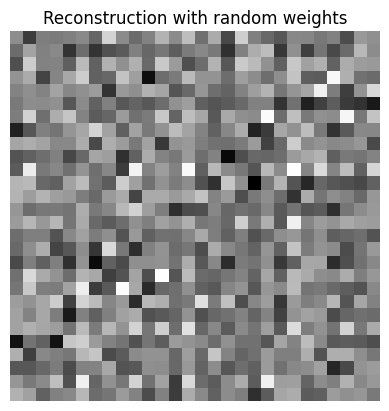

In [46]:
# RANDOM SHIT FOR NOW!
for image_batch, _ in train_dataloader:
    dream = autoencoder(image_batch)
    dream_sample = dream[0]
    plt.title("Reconstruction with random weights")
    plt.axis("off")
    plt.imshow(dream_sample.permute(1, 2, 0).detach().numpy(), cmap="gray");
    break

## Training AutoEncoder

In [53]:
encoder = Encoder(input_channels=1)
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder)

loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(params=autoencoder.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

epoch: 1. Train loss: 0.07150149345397949
epoch: 1. Val loss: 0.049737103283405304
epoch: 2. Train loss: 0.04036041721701622
epoch: 2. Val loss: 0.03238861635327339
epoch: 3. Train loss: 0.031835272908210754
epoch: 3. Val loss: 0.02987704612314701
epoch: 4. Train loss: 0.02849385142326355
epoch: 4. Val loss: 0.02579428255558014


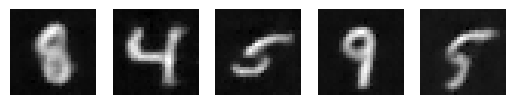

epoch: 5. Train loss: 0.026764631271362305
epoch: 5. Val loss: 0.025210238993167877
epoch: 6. Train loss: 0.023511383682489395
epoch: 6. Val loss: 0.02251524291932583
epoch: 7. Train loss: 0.023011650890111923
epoch: 7. Val loss: 0.021890126168727875
epoch: 8. Train loss: 0.022656751796603203
epoch: 8. Val loss: 0.021699920296669006


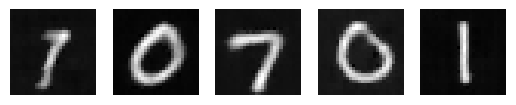

epoch: 9. Train loss: 0.022345252335071564
epoch: 9. Val loss: 0.02105470933020115
epoch: 10. Train loss: 0.02206733636558056
epoch: 10. Val loss: 0.020821673795580864
epoch: 11. Train loss: 0.02133467048406601
epoch: 11. Val loss: 0.02028767578303814
epoch: 12. Train loss: 0.021211855113506317
epoch: 12. Val loss: 0.02020055055618286


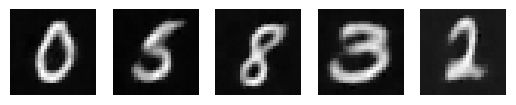

epoch: 13. Train loss: 0.021104678511619568
epoch: 13. Val loss: 0.020075906068086624
epoch: 14. Train loss: 0.021031642332673073
epoch: 14. Val loss: 0.019968504086136818
epoch: 15. Train loss: 0.020937329158186913
epoch: 15. Val loss: 0.019972415640950203
epoch: 16. Train loss: 0.020711524412035942
epoch: 16. Val loss: 0.01976640708744526


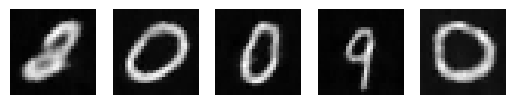

epoch: 17. Train loss: 0.020705072209239006
epoch: 17. Val loss: 0.019765589386224747
epoch: 18. Train loss: 0.020660480484366417
epoch: 18. Val loss: 0.01971122808754444
epoch: 19. Train loss: 0.020647207275032997
epoch: 19. Val loss: 0.01970314048230648
epoch: 20. Train loss: 0.020629405975341797
epoch: 20. Val loss: 0.019669407978653908


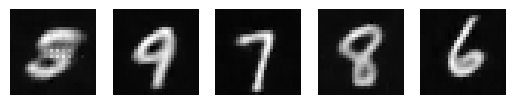

In [54]:
epochs = 20

for epoch in range(epochs):
    # Train step
    autoencoder.train()
    train_loss = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        
        dream = autoencoder(image_batch)
        loss = loss_fn(dream, image_batch)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch + 1}. Train loss: {train_loss / len(train_dataloader)}")
    lr_scheduler.step()

    # Val step
    autoencoder.eval()
    with torch.inference_mode():
        val_loss = 0
        for image_batch, _ in val_dataloader:
            image_batch = image_batch.to(device)
    
            dream = autoencoder(image_batch)
            loss = loss_fn(dream, image_batch)
            val_loss += loss
    
        print(f"epoch: {epoch + 1}. Val loss: {val_loss / len(val_dataloader)}")

    if (epoch + 1) % 4 == 0:
        fig=plt.figure()
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.axis("off")
            plt.imshow(dream[i].permute(1, 2, 0).detach().numpy(), cmap="gray")
        plt.show();

In [97]:
latent = torch.rand((1, 8, 1, 1))

In [98]:
with torch.inference_mode():
    dream = autoencoder.decoder(latent)

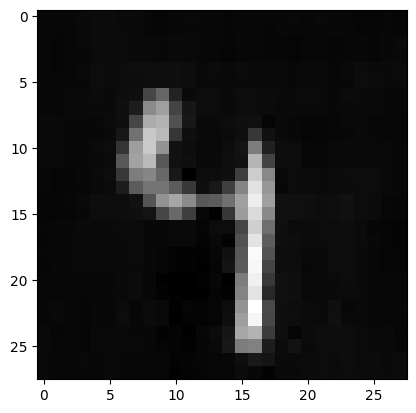

In [99]:
plt.imshow(dream.squeeze(0).permute(1, 2, 0), cmap="gray");